In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc

import torch

gc.collect()
torch.cuda.empty_cache()

In [3]:
# !pip install rouge_score
# !pip install datasets==1.0.2
# !pip install transformers==4.24.0
# !pip install transformer-utils
# !pip install packaging

In [4]:
%cd ~/aiffel/Aiffelthon_koBART
!pip install -r requirements.txt

/aiffel/aiffel/Aiffelthon_koBART


In [5]:
# !pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15772393220349756525,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14474280960
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15661048736080087062
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [7]:
# %cd ~/aiffel/Aiffelthon_kobart
# !wget https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_trainer.py
# !wget https://github.com/huggingface/transformers/blob/main/src/transformers/utils/import_utils.py
# !wget https://raw.githubusercontent.com/huggingface/transformers/main/src/transformers/models/encoder_decoder/modeling_encoder_decoder.py
# !wget https://raw.githubusercontent.com/huggingface/transformers/main/src/transformers/configuration_utils.py

In [8]:
# %cd ~/aiffel/Aiffelthon_kobart
# !wget https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/seq2seq/seq2seq_training_args.py

In [9]:
# %cd ~/aiffel/Aiffelthon_kobart
# !wget https://raw.githubusercontent.com/huggingface/transformers/main/src/transformers/modeling_outputs.py

In [10]:
import argparse
import datasets
import logging
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import DataLoader, Dataset
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from tqdm import tqdm
from transformers import modeling_outputs
import sys
sys.path.append('~/aiffel/Aiffelthon_koBART')

# from seq2seq_trainer import Seq2SeqTrainer
# from transformers import TrainingArguments
# from seq2seq_training_args import Seq2SeqTrainingArguments
# from dataclasses import dataclass, field
# from typing import Optional

In [11]:
# %cd ~/aiffel/Aiffelthon_koBART/data
# !unzip ~/aiffel/Aiffelthon_koBART/data/train_20per_onesetn.zip
# !unzip ~/aiffel/Aiffelthon_koBART/data/val_20per_onesetn.zip

In [12]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v1')
model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-base-v1')

#gogamza/kobart-base-v1

In [13]:
print(tokenizer)
print(model)

PreTrainedTokenizerFast(name_or_path='gogamza/kobart-base-v1', vocab_size=30000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'})
BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNor

In [14]:
train_df = pd.read_csv('~/aiffel/Aiffelthon_koBART/data/train_20per.csv')
train_df.head()

,Unnamed: 0,input_documant,sentence_20%
0,0,"지어내버린 대목부터는 흥분이 버썩 줄어지었다 ──. ""선생님! 또 기침이 나고 토...",자신을 배반한 제 계집과 세상이 엎드려 죄 사하기를 빌 때까지 죽지 아니하겠다는 H...
1,1,이 송아지가 젖을 떼우고 집으로 끌고 오던 날은 첨지는 개선장군이 성안 에 들어올...,젖뗀 송아지를 집으로 끌고 오던 날 어깨춤을 추면서 소 들어간다고 고함을 지르는 첨...
2,2,어떤 여름날 밤 손주딸에게 관한 불길한 꿈을 꾼 이 한머니는 이튿날 조반 후에 생...,손주딸의 관한 불길한 꿈을 꾼 한머니는 백여 리 떨어진 손주딸의 집에를 가보기로 하...
3,3,이러한 가운데서 왕후는 자기의 입장을 위태롭게 여기고 겸하여 장래 자기 의 몸으로...,자기는 태자의 위를 동경하거나 부러워한 적이 없으며 이 나라의 충성된 신자로서 공주...
4,4,“가겠소.” “언니가 나오시면 일러드 리겠으니 그때까지는 찾아오지 않으시는 것이 ...,자신의 신변을 염려하여 빠른 걸음으로 골목을 빠져나와 침착한 의식을 회복하면서 어수...


In [15]:
test_df = pd.read_csv('~/aiffel/Aiffelthon_koBART/data/val_20per.csv')
test_df.head()

,Unnamed: 0,input_documant,sentence_20%
0,0,러시아 황실이 제공한 임시공관에서 오전 내내 쉬며 지냈다. 오늘 아침 우리 임시공...,러시아에서 제공한 임시공관에서 쉬면서 아침에 태극기를 발코니 위에 게양했는데 모스크...
1,1,위에서 살펴본 방법으로 배우자 공제건수를 종합소득과 근로소득의 경우로 나누어 추정하...,기본공제액 확대 시 배우자 기본공제액 확대에 따른 공제 규모 증가분에 평균 실효세율...
2,2,우리나라 공공기관의 현황 분석을 시작으로 공공기관을 체계적으로 평가하기 시작하였다....,공공기관 정부 지원 예산안 평가에서는 일부 공공기관들이 여유자금을 과다하게 보유하고...
3,3,"그런 점에서 볼 때, 박영민씨 경우는 이례적인 케이스로 꼽힌다. 프로게이머 특성상...",박 씨는 기초 지식이 부족해 영어 문답을 통째로 외우다시피 하며 공무원 시험 준비를...
4,4,도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 단점을...,도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 점이 ...


In [16]:
train_df.drop(labels = 'Unnamed: 0', axis=1, inplace=True)
test_df.drop(labels = 'Unnamed: 0', axis=1, inplace=True)

In [17]:
test_df.head()

,input_documant,sentence_20%
0,러시아 황실이 제공한 임시공관에서 오전 내내 쉬며 지냈다. 오늘 아침 우리 임시공...,러시아에서 제공한 임시공관에서 쉬면서 아침에 태극기를 발코니 위에 게양했는데 모스크...
1,위에서 살펴본 방법으로 배우자 공제건수를 종합소득과 근로소득의 경우로 나누어 추정하...,기본공제액 확대 시 배우자 기본공제액 확대에 따른 공제 규모 증가분에 평균 실효세율...
2,우리나라 공공기관의 현황 분석을 시작으로 공공기관을 체계적으로 평가하기 시작하였다....,공공기관 정부 지원 예산안 평가에서는 일부 공공기관들이 여유자금을 과다하게 보유하고...
3,"그런 점에서 볼 때, 박영민씨 경우는 이례적인 케이스로 꼽힌다. 프로게이머 특성상...",박 씨는 기초 지식이 부족해 영어 문답을 통째로 외우다시피 하며 공무원 시험 준비를...
4,도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 단점을...,도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 점이 ...


In [18]:
print('전체 샘플 수 :', len(train_df['input_documant']))
print('전체 샘플 수 :', len(train_df['sentence_20%']))

전체 샘플 수 : 73431
전체 샘플 수 : 73431


text_len의 최소 길이 : 67
text_len의 최대 길이 : 404
text_len의 평균 길이 : 188.93805068703952
headlines_len의 최소 길이 : 3
headlines_len의 최대 길이 : 30
headlines_len의 평균 길이 : 17.836336152306245


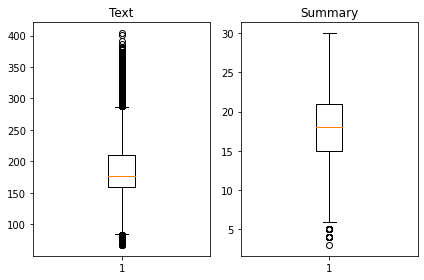

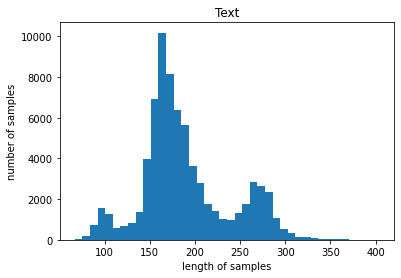

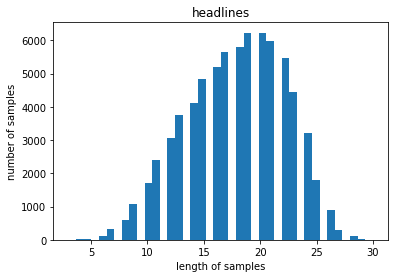

In [19]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in train_df['input_documant']]
headlines_len = [len(s.split()) for s in train_df['sentence_20%']]

print('text_len의 최소 길이 : {}'.format(np.min(text_len)))
print('text_len의 최대 길이 : {}'.format(np.max(text_len)))
print('text_len의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines_len의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines_len의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines_len의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
train_df = train_df.dropna(axis=0)

In [21]:
# pad_index = tokenizer.pad_token_id
# 이거는 위에서 분석한 내용으로 지정해야할 듯
def add_padding_data(inputs, max_len):
        pad_index = tokenizer.pad_token_id
        if len(inputs) < max_len:
            pad = np.array([pad_index] *(max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:max_len]

        return inputs 
    ## max_len, pad_len을 구해야함

In [22]:
def add_ignored_data(inputs, max_len, ignore_index):
        if len(inputs) < max_len:
            pad = np.array([ignore_index] *(max_len - len(inputs))) # ignore_index즉 -100으로 패딩을 만들 것인데 max_len - lne(inpu)
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:max_len]

        return inputs

In [42]:
encoder_max_length=512
decoder_max_length=128
ignore_index = -100
    
def tokenizer_data(inputs_data, target_data, encoder_max_length, decoder_max_length, ignore_index):
    input_ids = []
    label_id = []
    label_ids = []
    dec_input_ids = []
    
    for i in tqdm(range(len(inputs_data)//20)):
       input_ids.append(add_padding_data(tokenizer.encode(inputs_data[i].replace('\n', " ")), encoder_max_length))

    for i in tqdm(range(len(target_data)//20)):
       label_id.append(tokenizer.encode(target_data[i].replace('\n', " ")))

    for i in tqdm(range(len(target_data)//20)):
       label_id[i].append(tokenizer.eos_token_id)
       label_ids.append(add_ignored_data(label_id[i], decoder_max_length, ignore_index))

    for i in tqdm(range(len(target_data)//20)):  
           dec_input_id = [tokenizer.eos_token_id]
           dec_input_id += label_ids[i][:-1]
           dec_input_ids.append(add_padding_data(dec_input_id, decoder_max_length))
            
    pad_token_id = tokenizer.pad_token_id 
    
    result_data = {'input_ids': torch.FloatTensor(np.array(input_ids)),                
                    'decoder_input_ids': torch.FloatTensor(np.array(dec_input_ids)),
                    'labels': torch.FloatTensor(np.array(label_ids)),
                    'attention_mask' : torch.FloatTensor((np.array(input_ids) != pad_token_id).astype(float)),
                    'decoder_attention_mask' : torch.FloatTensor((np.array(dec_input_ids) != pad_token_id).astype(float))
                    }
    
    return result_data

In [43]:
train_inputs =\
tokenizer_data(train_df['input_documant'], train_df['sentence_20%'], encoder_max_length, decoder_max_length, ignore_index )

100%|██████████| 3671/3671 [00:00<00:00, 82562.29it/s]


In [44]:
test_inputs =\
tokenizer_data(test_df['input_documant'], test_df['sentence_20%'], encoder_max_length, decoder_max_length, ignore_index )

100%|██████████| 457/457 [00:00<00:00, 49641.23it/s]


In [45]:
train_inputs['input_ids']

tensor([[2.0681e+04, 9.5170e+03, 2.0860e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4025e+04, 1.4789e+04, 1.1696e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4593e+04, 1.6256e+04, 9.5010e+03,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        ...,
        [1.4210e+04, 1.0777e+04, 1.2005e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4220e+04, 1.4890e+04, 1.4578e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4317e+04, 1.3714e+04, 2.5700e+02,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00]])

In [46]:
torch.FloatTensor(train_inputs['input_ids'])

tensor([[2.0681e+04, 9.5170e+03, 2.0860e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4025e+04, 1.4789e+04, 1.1696e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4593e+04, 1.6256e+04, 9.5010e+03,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        ...,
        [1.4210e+04, 1.0777e+04, 1.2005e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4220e+04, 1.4890e+04, 1.4578e+04,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00],
        [1.4317e+04, 1.3714e+04, 2.5700e+02,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00]])

TypeError: __init__() got an unexpected keyword argument 'input_ids'

In [25]:
train_inputs_df = pd.DataFrame(zip(train_inputs['input_ids'], train_inputs['attention_mask'], train_inputs['decoder_input_ids']\
                              , train_inputs['decoder_attention_mask'], train_inputs['labels']),\
                               columns=['input_ids','attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'])
train_inputs_df.head()

,input_ids,attention_mask,decoder_input_ids,decoder_attention_mask,labels
0,"[20681, 9517, 20860, 21368, 18059, 15768, 1621...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[16752, 14204, 10774, 13591, 14061, 14159, 123...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[16751, 14203, 10773, 13590, 14060, 14158, 123..."
1,"[14025, 14789, 11696, 14824, 19326, 12007, 186...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[19327, 10095, 14790, 11697, 14405, 20294, 184...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[19326, 10094, 14789, 11696, 14404, 20293, 183..."
2,"[14593, 16256, 9501, 15294, 14316, 12258, 1003...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14317, 12259, 10036, 12025, 15502, 14136, 927...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14316, 12258, 10035, 12024, 15501, 14135, 926..."
3,"[15035, 14591, 11264, 14949, 13756, 9698, 2258...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14048, 14576, 14439, 14501, 14065, 10444, 141...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14047, 14575, 14438, 14500, 14064, 10443, 141..."
4,"[14128, 8981, 9060, 21007, 1547, 14128, 11767,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14630, 14095, 25420, 24847, 14331, 17659, 241...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14629, 14094, 25419, 24846, 14330, 17658, 241..."


In [26]:
test_inputs_df = pd.DataFrame(zip(test_inputs['input_ids'], test_inputs['attention_mask'], test_inputs['decoder_input_ids']\
                              , test_inputs['decoder_attention_mask'], test_inputs['labels']),\
                               columns=['input_ids','attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'])
test_inputs_df.head()

,input_ids,attention_mask,decoder_input_ids,decoder_attention_mask,labels
0,"[15976, 14775, 18144, 26798, 17711, 9115, 1738...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[15977, 14031, 26799, 17712, 9116, 17385, 1616...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[15976, 14030, 26798, 17711, 9115, 17384, 1616..."
1,"[20341, 16354, 10888, 19559, 15007, 12060, 283...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[15450, 23559, 11725, 14780, 14045, 15008, 120...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[15449, 23558, 11724, 14779, 14044, 15007, 120..."
2,"[15736, 19243, 12024, 22836, 24786, 18285, 192...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[19244, 14296, 14424, 15400, 11700, 14654, 142...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[19243, 14295, 14423, 15399, 11699, 14653, 142..."
3,"[14376, 16419, 14583, 17340, 22588, 10748, 116...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14170, 16641, 16103, 14035, 15648, 15545, 136...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14169, 16640, 16102, 14034, 15647, 15544, 136..."
4,"[16522, 10595, 14053, 17047, 14034, 10832, 140...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[16523, 10596, 14054, 17048, 14035, 10833, 140...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[16522, 10595, 14053, 17047, 14034, 10832, 140..."


In [27]:
train_inputs_df.reset_index(inplace=True, drop=True)
test_inputs_df.reset_index(inplace=True, drop=True)

In [28]:
train_inputs_df.head()

,input_ids,attention_mask,decoder_input_ids,decoder_attention_mask,labels
0,"[20681, 9517, 20860, 21368, 18059, 15768, 1621...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[16752, 14204, 10774, 13591, 14061, 14159, 123...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[16751, 14203, 10773, 13590, 14060, 14158, 123..."
1,"[14025, 14789, 11696, 14824, 19326, 12007, 186...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[19327, 10095, 14790, 11697, 14405, 20294, 184...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[19326, 10094, 14789, 11696, 14404, 20293, 183..."
2,"[14593, 16256, 9501, 15294, 14316, 12258, 1003...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14317, 12259, 10036, 12025, 15502, 14136, 927...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14316, 12258, 10035, 12024, 15501, 14135, 926..."
3,"[15035, 14591, 11264, 14949, 13756, 9698, 2258...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14048, 14576, 14439, 14501, 14065, 10444, 141...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14047, 14575, 14438, 14500, 14064, 10443, 141..."
4,"[14128, 8981, 9060, 21007, 1547, 14128, 11767,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14630, 14095, 25420, 24847, 14331, 17659, 241...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14629, 14094, 25419, 24846, 14330, 17658, 241..."


In [29]:
from datasets import Dataset
train_data = Dataset.from_pandas(train_inputs_df) 
val_len = len(test_inputs_df) // 2
val_data = Dataset.from_pandas(test_inputs_df[:val_len])
test_data=Dataset.from_pandas(test_inputs_df[val_len:])

In [30]:
print(train_data)
print()
print(val_data)
print()
print(test_data)

Dataset(features: {'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'decoder_input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'decoder_attention_mask': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 3671)

Dataset(features: {'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'decoder_input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'decoder_attention_mask': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 228)

Dataset(features: {'input_ids': Sequence(feature=Valu

In [30]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],)

In [31]:
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],)

In [32]:
type(train_data)

datasets.arrow_dataset.Dataset

In [33]:
train_data[0]

{'input_ids': tensor([20681,  9517, 20860, 21368, 18059, 15768, 16217, 14536, 11528, 18396,
         12332, 22145,  1700, 15945,   245, 14050, 24515,  9743,   232, 14153,
         14040, 12875, 12034, 27930, 14521, 13673, 12034, 26354, 14562, 14381,
         18112,   232, 16530, 17882, 14042, 14083, 11264, 14707, 14674, 12332,
         14202, 14642, 15170, 15995, 14417, 16009, 16526, 16389, 14203, 10773,
         13590, 14060, 14158, 12344,  9120, 16389, 14299, 14513, 14060, 14115,
         16663, 22166, 14067, 16624, 25376, 26303, 19951, 16647, 10313, 16426,
         14031, 21443, 15739, 18526, 16530, 17704, 17704, 14674, 12332, 14202,
         13586, 10322, 14562,   233, 14651, 14025, 22844, 14971,  9698, 24009,
         14523, 15764, 23046, 22794, 15400, 16391, 10443, 18941, 13594, 14121,
          1700, 14321, 28943, 16767, 14161, 20067, 15400,   243, 14664, 12024,
         14074, 18821, 15706, 10884, 16402, 29620, 14246, 15636, 27043, 14955,
         14651, 15420, 16391, 14120, 20

In [ ]:
# 오류는 기락님 코드 따라가보면서 해결해봐라 
# 그리고 제발 검색좀 해라 
# 너 머리로 해결하려고 하지말고

In [34]:
from transformers import EncoderDecoderModel

kobart_shared = EncoderDecoderModel.from_encoder_decoder_pretrained("gogamza/kobart-base-v2", "gogamza/kobart-base-v2", tie_encoder_decoder=True)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Some weights of the model checkpoint at gogamza/kobart-base-v2 were not used when initializing BartForCausalLM: ['encoder.layers.1.self_attn.out_proj.bias', 'encoder.layers.0.final_layer_norm.weight', 'encoder.embed_tokens.weight', 'encoder.layers.2.fc1.bias', 'encoder.layers.0.self_attn_layer_norm.weight', 'encoder.layers.4.self_attn.k_proj.bias', 'encoder.layers.1.fc1.bias', 'encoder.layers.5.self_attn.v_proj.bias', 'encoder.layers.2.fc2.weight', 'encoder.layers.5.fc2.bias', 'encoder.layers.3.self_attn.k_proj.bias', 'encoder.layers.5.fc1.bias', 'encoder.layers.2.final_layer_norm.weight', 'encoder.layers.4.final_layer_norm.weight', 'encoder.layers.3.self_attn.q_proj.weight', 'encoder.la

In [35]:
kobart_shared.train

<bound method Module.train of EncoderDecoderModel(
  (encoder): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Layer

In [36]:
from transformers import EncoderDecoderConfig
kobart_shared.config.decoder_start_token_id = tokenizer.bos_token_id                                             
kobart_shared.config.eos_token_id = tokenizer.eos_token_id

# sensible parameters for beam search
# set decoding params                               
kobart_shared.config.max_length = 128
kobart_shared.config.early_stopping = True
kobart_shared.config.no_repeat_ngram_size = 3
kobart_shared.config.length_penalty = 2.0
kobart_shared.config.num_beams = 4
kobart_shared.config.vocab_size = kobart_shared.config.encoder.vocab_size

In [37]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),}

In [38]:
batch_size=4
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    num_train_epochs = 10,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    do_train=True,
    do_eval=True,
    logging_steps=500, 
    save_steps=16, 
    eval_steps=500, 
    warmup_steps=500, 
    overwrite_output_dir=True,
    save_total_limit=1,
    fp16=True,)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=kobart_shared,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,)
trainer.train()

Using cuda_amp half precision backend
The `config.pad_token_id` is `None`. Using `config.eos_token_id` = 1 for padding..
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3671
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 9180
  Number of trainable parameters = 146899968
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [67,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:975: indexSelectLargeIndex: block: [67,0,0], thread: [97,0,0] Assertion `srcIndex < 

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
model.config

In [ ]:
type(model.forward)

In [ ]:
train_inputs['input_ids'] = torch.Tensor(train_inputs['input_ids']).to(torch.int64)
train_inputs['attention_mask'] = torch.Tensor(train_inputs['attention_mask']).to(torch.int64)
train_inputs['decoder_input_ids'] = torch.Tensor(train_inputs['decoder_input_ids']).to(torch.int64)
train_inputs['decoder_attention_mask'] = torch.Tensor(train_inputs['decoder_attention_mask']).to(torch.int64)
train_inputs['labels'] = torch.Tensor(train_inputs['labels']).to(torch.int64)

In [ ]:
model(input_ids=train_inputs['input_ids'],
    attention_mask=train_inputs['attention_mask'],
    decoder_input_ids=train_inputs['decoder_input_ids'],
    decoder_attention_mask=train_inputs['decoder_attention_mask'],
    labels=train_inputs['labels'], return_dict=True)

In [ ]:
type(model)

In [ ]:
type(model.model)

In [ ]:
self.model(input_ids=inputs['input_ids'],
                          attention_mask=attention_mask,
                          decoder_input_ids=inputs['decoder_input_ids'],
                          decoder_attention_mask=decoder_attention_mask,
                          labels=inputs['labels'], return_dict=True)